# PyTorch ConvNet

Autor: Gabriel Dornelles Monteiro, junho de 2022. Notebook nº6.

Neste notebook, iremos construir utilizando o framework PyTorch, o mesmo modelo que construimos anteriormente com os módulos que desenvolvemos na biblioteca Airi. Para isso, verá que o processo é extremamente semelhante, com o diferencial que o PyTorch nos proporciona uma gama gigantesca de módulos com forward e backward implementados! Além disso, construiremos uma ConvNet parecida mas com uma performance maior, alcançando os 80% de precisão no set de validação do CIFAR10.

In [131]:
import copy
import time

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt
import numpy as np
import cv2

In [276]:
batch_size = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.485, 0.485, 0.406), (0.229, 0.224, 0.225))])


image_datasets = {x: CIFAR10(root='./data', train=True if x=="train" else False ,download=True , transform=transform) for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(class_names)

Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Nosso dataloaders, é um dicionário contendo um dataloader para treino e outro para validação. 

O Dataloader é um iteravél que nos entrega uma imagem e um label associado, ou neste caso, como especificamos o batch_size em sua criação, nos retorna 64 imagens e os 64 labels associados por iteração. 

Dessa forma, para acessarmos nosso dataset já organizado em tensores e dividido em batches, basta escrevermos:

```py
for image, label in dataloader:
    # 64 imagens e 64 labels associados por iteração até terminarmos o dataset
    batch_images = image
    batch_labels = label
```

## Construção do modelo
Construiremos agora o nosso modelo com o PyTorch, lembre que nosso modelo construido com nossa lib era:

```py
self.model = [
            Conv2D(in_channels=3, num_filters=16,filter_size=5, stride=1, pad=0),
            Relu(),
            Conv2D(in_channels=16, num_filters=16, filter_size=5, stride=1, pad=0),
            Relu(),
            Flatten(),
            Linear(input_size=9216, hidden_size=120, reg=self.reg),
            Relu(),
            Linear(input_size=120, hidden_size=84, reg=self.reg),
            Relu(),
            Linear(input_size=84, hidden_size=10, reg=self.reg),
            Softmax()
        ]
```
Manteremos o código de maneira extremamente semelhante, apenas não utilizaremos o parâmetro de regularização e mudaremos o nome de alguns argumentos:

In [48]:
class TorchDemoConvNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=9216, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
            nn.Softmax()
        )
    
    def forward(self, x):
        return self.backbone(x)
    

model = TorchDemoConvNet()

# Treinamento
Definiremos agora o número de épocas do treinamento, a loss function que utilizaremos (Cross Entropy Loss), o device (onde será treinado o modelo, cpu ou cuda), e definiremos qual otimizador será utilizado para a descida de gradiente junto ao seu learning rate:

In [49]:
epoches = 20
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda")

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

O loop de treinamento é feito da seguinte maneira:

```py

for epoch in range(num_epoches):

    model.train()
    
    for x, y in dataloader:
        # x é nossa imagem, y o label associado (em batches)
        x, y = x.to(device), y.to(device) # passamos ambas para cpu ou gpu caso utilize cuda
        optimizer.zero_grad() # Zeramos os gradientes do nosso otimizador, que os acumula por padrão
        predictions = model(x) # passamos ao nosso modelo a imagem, ele retornara sua predição
        loss = criterion(predictions, y) # definimos o erro entre a verdadeira label e a label prevista pelo modelo
        loss.backward() # Fazemos o backward deste erro pelos módulos de nosso modelo
        optimizer.step() # Aplicamos o update nos pesos
```

É importante declaramos se nosso modelo esta treinando ou se está avaliando, dessa maneira, o PyTorch saberá se precisa ou não guardar informações de resultados que ocorreram durante o forward. 

Para fazermos isso apenas escrevemos ```model.train()``` ou ```model.eval()```

In [53]:
import datetime

def train(model, criterion, optimizer, epoches):

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  losses = []
  accs = []
  start = time.time()
  for epoch in range(epoches):  

      print(f"\nEpoch: {epoch} / {(epoches-1)}")
      print("----------")

      epoch_loss = 0
      model.train()

      for x, y in dataloaders["train"]:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        predictions = model(x)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
      loss = epoch_loss / len(dataloaders["train"])
      print(f"Epoch {epoch} Training Loss: {loss:.4f}")
      losses.append(loss)
      
      with torch.no_grad():
        model.eval()
        correct = 0
        samples = 0
        for x, y in dataloaders["val"]:
          x, y = x.to(device), y.to(device)
          predictions = model(x)
          _, predictions = predictions.max(1)
          correct += (predictions == y).sum()
          samples += predictions.size(0)

        val_acc = int(correct)/samples
        print(f"Validation accuracy: {val_acc}")
        accs.append(val_acc)
        if val_acc > best_acc:
          best_acc = val_acc
          best_model_wts = copy.deepcopy(model.state_dict())
    
  end = time.time()
  model.load_state_dict(best_model_wts)
  torch.save(model.state_dict(),"torch_convnet.pth")
  time_elapsed = datetime.timedelta(seconds=end-start)
  print(f"Training Time: {time_elapsed}")
  print(f"Best accuracy: {best_acc}")


  plt.style.use('seaborn')
  accuracy = np.array(accs) 
  fig, ax = plt.subplots(figsize = (8, 4.5))
  ax.plot(accuracy, color='purple', label='Model Accuracy') 
  ax.set(title="Accuracy over epochs", 
          xlabel='Epoch',
          ylabel='Accuracy') 


  loss_list = np.array(losses) 
  fig, ax = plt.subplots(figsize = (8, 4.5))
  ax.plot(loss_list, color='red', label='Loss') 
  ax.set(title="Train Loss over epochs", 
          xlabel='Epoch',
          ylabel='Loss') 

  return model


Epoch: 0 / 19
----------
Epoch 0 Training Loss: 2.0146
Validation accuracy: 0.482

Epoch: 1 / 19
----------
Epoch 1 Training Loss: 1.9615
Validation accuracy: 0.514

Epoch: 2 / 19
----------
Epoch 2 Training Loss: 1.9194
Validation accuracy: 0.5342

Epoch: 3 / 19
----------
Epoch 3 Training Loss: 1.8918
Validation accuracy: 0.5576

Epoch: 4 / 19
----------
Epoch 4 Training Loss: 1.8677
Validation accuracy: 0.5719

Epoch: 5 / 19
----------
Epoch 5 Training Loss: 1.8485
Validation accuracy: 0.5803

Epoch: 6 / 19
----------
Epoch 6 Training Loss: 1.8323
Validation accuracy: 0.5848

Epoch: 7 / 19
----------
Epoch 7 Training Loss: 1.8162
Validation accuracy: 0.5863

Epoch: 8 / 19
----------
Epoch 8 Training Loss: 1.7998
Validation accuracy: 0.6058

Epoch: 9 / 19
----------
Epoch 9 Training Loss: 1.7871
Validation accuracy: 0.5942

Epoch: 10 / 19
----------
Epoch 10 Training Loss: 1.7754
Validation accuracy: 0.6075

Epoch: 11 / 19
----------
Epoch 11 Training Loss: 1.7625
Validation accurac

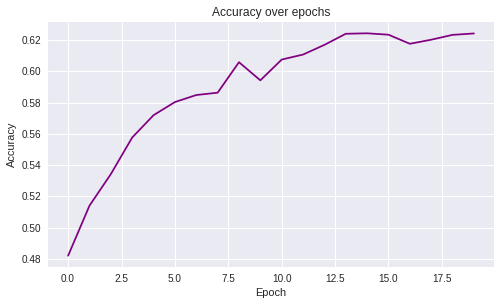

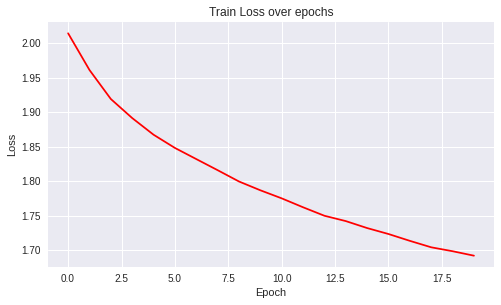

In [54]:
model = train(model, criterion, optimizer, epoches)

O Modelo que construimos no PyTorch tem perfomance extremamente semelhante ao que construimos do zero, possui uma precisão máxima de validação em torno de 62%, mesma precisão alcançada no modelo construido com a Airi.

Agora que utilizaremos o PyTorch, não precisaremos mais nos preocupar em toda parte de cálculo, derivadas e backward, veja que o framework fará todo este processo por debaixo dos panos!

Nossa tarefa agora é entender o que estes módulos fazem, quais devemos juntar, e como podemos construir modelos que consigam otimizar e aproximar as funções que desejamos. 

Façamos agora um modelo utilizando de blocos que não sabemos ou não queremos implementar, mas que sabemos o que fazem, como o MaxPool e o Batchnorm2d:


In [431]:
class BetterConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(in_features=2048, out_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000, out_features=10),
            nn.Softmax()
        )
    
    def forward(self, x):
        return self.backbone(x)
      
model = BetterConvNet()
epoches = 50
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda")

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)


Epoch: 0 / 49
----------
Epoch 0 Training Loss: 1.9888
Validation accuracy: 0.5374

Epoch: 1 / 49
----------
Epoch 1 Training Loss: 1.8452
Validation accuracy: 0.6052

Epoch: 2 / 49
----------
Epoch 2 Training Loss: 1.7978
Validation accuracy: 0.6624

Epoch: 3 / 49
----------
Epoch 3 Training Loss: 1.7696
Validation accuracy: 0.6765

Epoch: 4 / 49
----------
Epoch 4 Training Loss: 1.7445
Validation accuracy: 0.6912

Epoch: 5 / 49
----------
Epoch 5 Training Loss: 1.7259
Validation accuracy: 0.7097

Epoch: 6 / 49
----------
Epoch 6 Training Loss: 1.7071
Validation accuracy: 0.6937

Epoch: 7 / 49
----------
Epoch 7 Training Loss: 1.6931
Validation accuracy: 0.7328

Epoch: 8 / 49
----------
Epoch 8 Training Loss: 1.6821
Validation accuracy: 0.7302

Epoch: 9 / 49
----------
Epoch 9 Training Loss: 1.6673
Validation accuracy: 0.7331

Epoch: 10 / 49
----------
Epoch 10 Training Loss: 1.6543
Validation accuracy: 0.7485

Epoch: 11 / 49
----------
Epoch 11 Training Loss: 1.6439
Validation accur

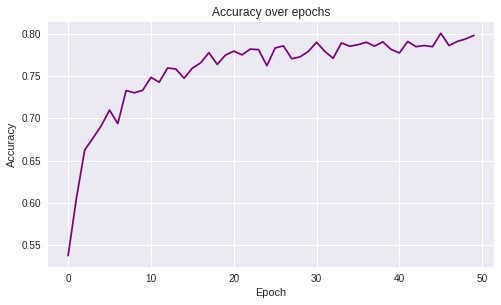

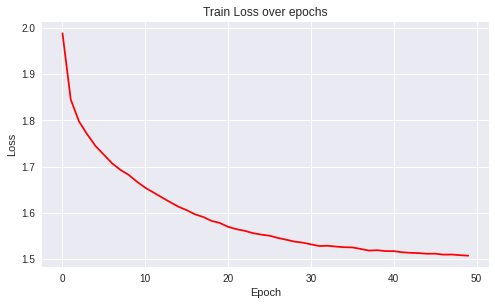

In [432]:
model = train(model, criterion, optimizer, epoches)

Alcançamos 80% de acurácia!, na sequência, visualizaremos dentro de nosso modelo, o que está sendo levado em consideração para gerar a escolha do modelo, para isso, iremos utilizar uma implementação deste artigo:

[Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

Abaixo, estão definidas algumas funções que nos permitirão visualizar as ativações dentro de nosso modelo:

In [427]:
from torch.nn import functional as F
# @Author: Kazuto Nakashima  => https://github.com/kazuto1011/grad-cam-pytorch
class _BaseWrapper(object):
    def __init__(self, model):
        super(_BaseWrapper, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.logits).to(self.device)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        self.image_shape = image.shape[2:]
        self.logits = self.model(image)
        self.probs = F.softmax(self.logits, dim=1)
        return self.probs.sort(dim=1, descending=True)  # ordered results

    def backward(self, ids):
        """
        Class-specific backpropagation
        """
        one_hot = self._encode_one_hot(ids)
        self.model.zero_grad()
        self.logits.backward(gradient=one_hot, retain_graph=True)

    def generate(self):
        raise NotImplementedError

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()

class GradCAM(_BaseWrapper):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure 2 on page 4
    """

    def __init__(self, model, candidate_layers=None):
        super(GradCAM, self).__init__(model)
        self.fmap_pool = {}
        self.grad_pool = {}
        self.candidate_layers = candidate_layers  # list

        def save_fmaps(key):
            def forward_hook(module, input, output):
                self.fmap_pool[key] = output.detach()

            return forward_hook

        def save_grads(key):
            def backward_hook(module, grad_in, grad_out):
                self.grad_pool[key] = grad_out[0].detach()

            return backward_hook

        # If any candidates are not specified, the hook is registered to all the layers.
        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name)))
                self.handlers.append(module.register_backward_hook(save_grads(name)))

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = F.adaptive_avg_pool2d(grads, 1)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)
        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam

class BackPropagation(_BaseWrapper):
    def forward(self, image):
        self.image = image.requires_grad_()
        return super(BackPropagation, self).forward(self.image)

    def generate(self):
        gradient = self.image.grad.clone()
        self.image.grad.zero_()
        return gradient

# Visualizando com o Grad-CAM

Veremos as ativações em cada uma das camadas de nosso modelo para algumas imagens:

Files already downloaded and verified
Files already downloaded and verified


/home/gabriel/.local/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


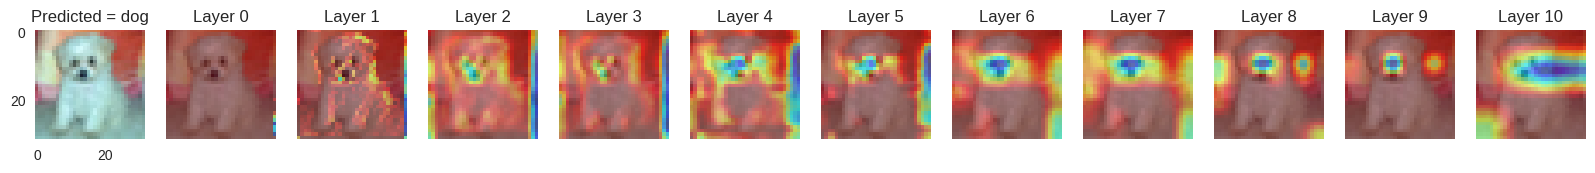

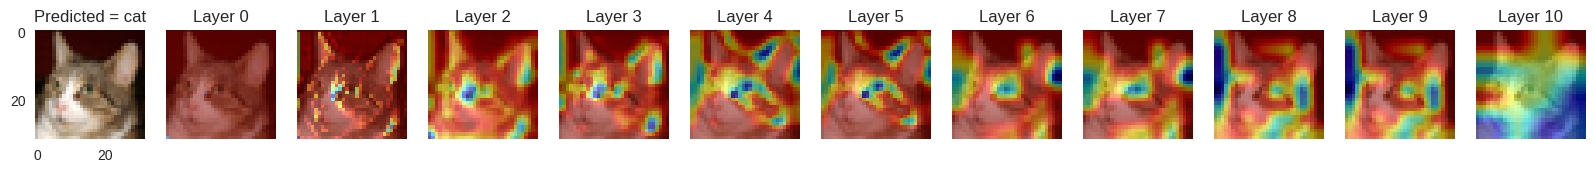

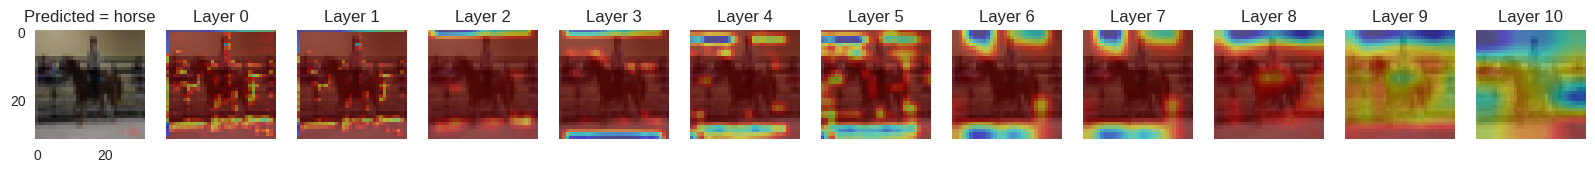

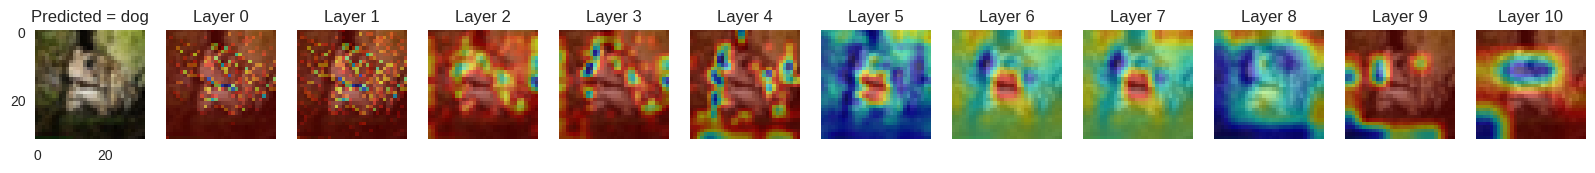

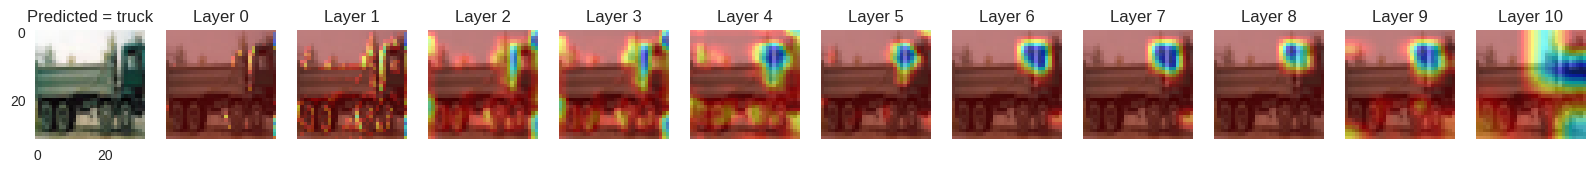

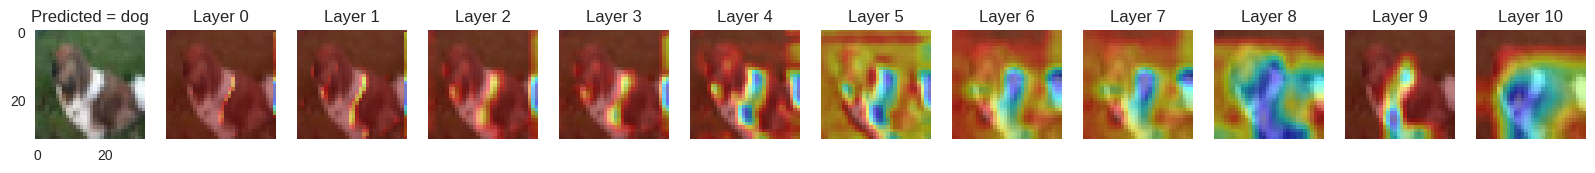

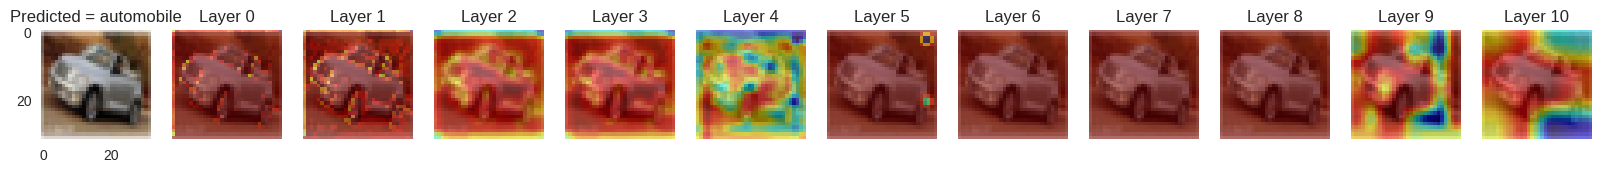

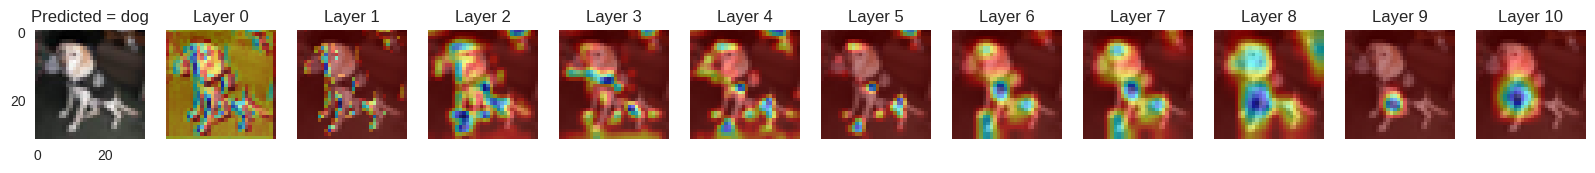

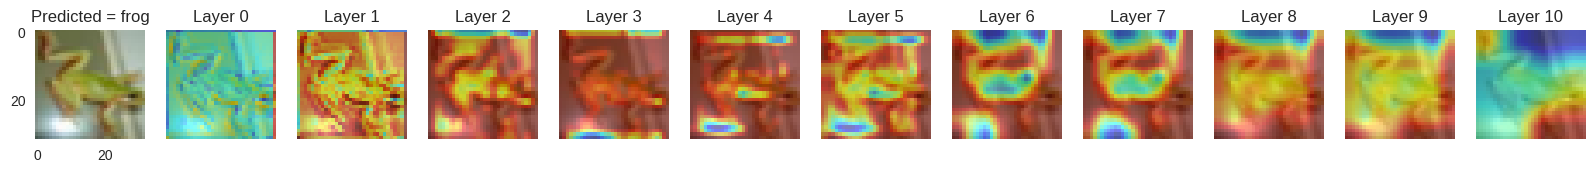

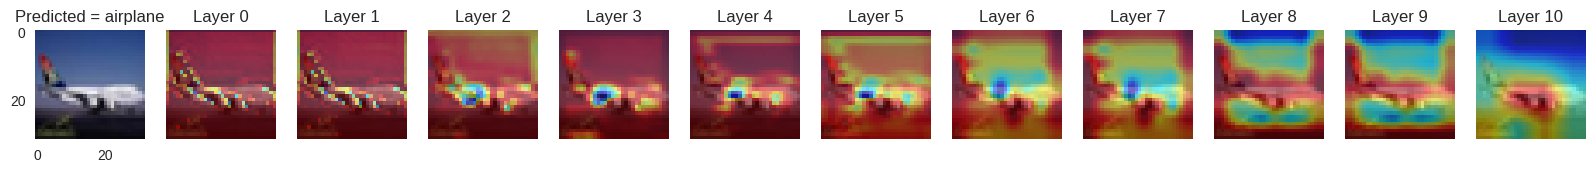

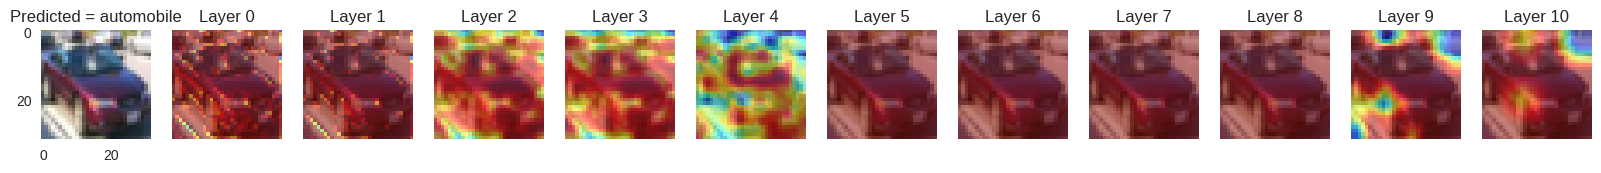

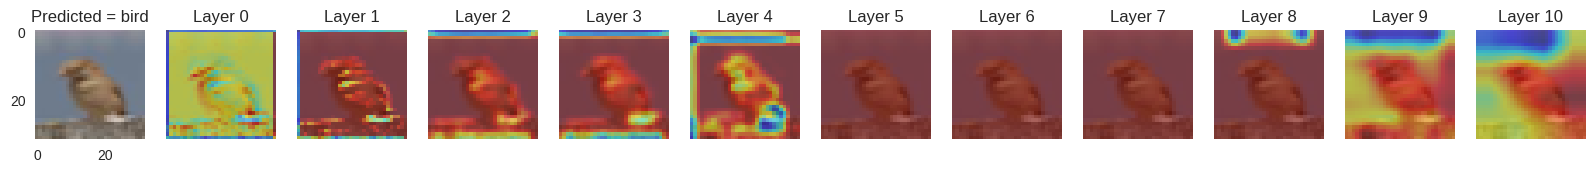

In [433]:
transform = transforms.Compose(
    [transforms.ToTensor()])

plot_datasets = {x: CIFAR10(root='./data', train=True if x=="train" else False ,download=True, transform=transform) for x in ['train','val']} # A version of the dataset without imagenet Mean and std, so we can visualize better

indexes = [510,911,8320,8341, 545, 502, 1564, 1571, 2035, 2040, 2045, 3034]
for idx in indexes:
   
    images = plot_datasets['val']
    images = images[idx][0] 
    plot_image = images
    images = images[None,:,:,:].cuda()

    model_answer = model(image_datasets["val"][idx][0][None,:,:,:].cuda())
    _, predictions = model_answer.max(1)
    predicted = class_names[predictions]
    bp = BackPropagation(model=model)
    probs, ids = bp.forward(images)  # sorted

    gcam = GradCAM(model=model)
    _ = gcam.forward(images)

    plot_image = plot_image.detach().cpu().numpy().transpose(1,2,0)


    gcam.backward(ids=ids[:, [0]])
    plt.figure(figsize=(20, 5), dpi=100, facecolor="white")
    cnt=1
    plt.subplot(1,12, cnt)
    plt.grid(False)
    plt.imshow(plot_image)
    plt.title(f"Predicted = {predicted}")
    for layer in range(0,11):
        regions = gcam.generate(target_layer=f"backbone.{layer}") # convs are 0 4 and 8
        regions = regions.detach().cpu().numpy()[0][0]
        cnt+=1
        regions = regions * 255
        regions = regions.astype(np.uint8)
        heatmap = cv2.applyColorMap(regions, cv2.COLORMAP_JET)
        mapped = cv2.addWeighted(heatmap, 0.5, (plot_image * 255).astype(np.uint8), 0.5, 0)
        plt.subplot(1,12, cnt)
        plt.grid(False)
        plt.axis(False)
        plt.title(f"Layer {layer}")
        plt.imshow(mapped)

---

Indo muito além da classificação, os modelos de detecção, segmentação, dentre muitas outras tarefas, utilizam os mesmos módulos que vimos e vários outros em conjunto. 

Entender o processo é importante, mas não é necessário conhecer todas as funções e suas derivadas, agora que já sabemos como tudo é feito, basta entendermos qual a proposta do módulo, o que ele faz, e como ele interage com os demais.